<a href="https://colab.research.google.com/github/Crepopcorn/IE4476_project/blob/main/IE4476_Project_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load Libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# Load images
def load_im():
    input_im, input_label = [], []
    resize = (224, 224)
    # Loop in folders
    for dirname, _, filenames in os.walk('/content/drive/My Drive/IE4476_dataset'):
        for filename in filenames:
            photo_path = os.path.join(dirname, filename)
            photo_class = dirname.split('/')[-1]
            try:
                read_im = cv2.imread(photo_path)
                input_im.append(cv2.resize(read_im, resize))

                if photo_class == 'rock':
                    input_label.append(0)
                elif photo_class == 'paper':
                    input_label.append(1)
                elif photo_class == 'scissor':
                    input_label.append(2)
            except:
                print(photo_path)
    # return list of images and another list of correponding labels
    return input_im, input_label

input_im, input_label = load_im()

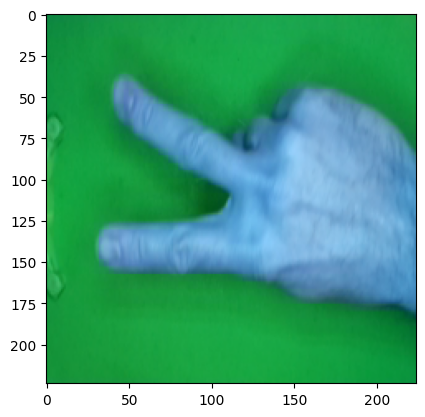

2


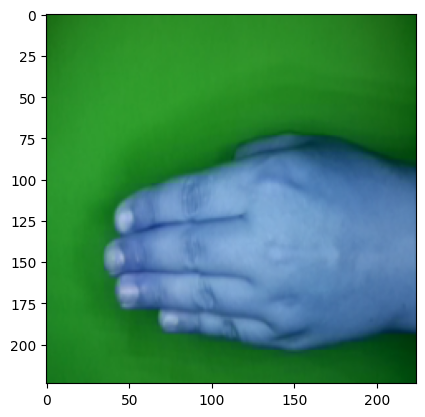

1


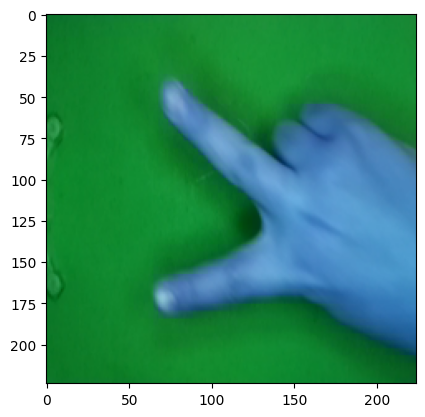

2


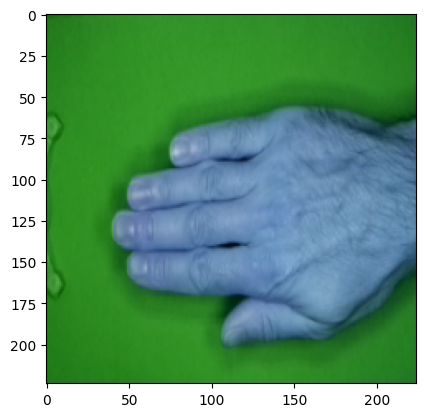

1


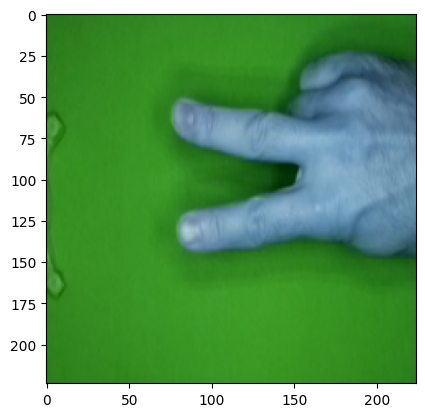

2


In [ ]:
# Checking code: Print photo and class
index_set = np.random.choice(len(input_label), size = 5, replace = False)
for index in index_set:
    # show images
    plt.imshow(input_im[index])
    plt.show()
    # show label
    print(input_label[index])

In [ ]:
# Train/Test split
def train_test_split(test_prop, input_im, input_label):
    # Random sampling of index
    test_size = int(np.floor(test_prop * len(input_label)))
    test_index = np.random.choice(len(input_label), size = test_size, replace = False)
    # Split
    train_x, test_x, train_y, test_y = np.delete(input_im, test_index, axis = 0), np.take(input_im, test_index, axis = 0), np.delete(input_label, test_index, axis = 0), np.take(input_label, test_index, axis = 0)
    # Return train and test sets for both images and labels
    return train_x, test_x, train_y, test_y, test_index

# 80/20 split for small data set
test_prop = 0.2
train_x, test_x, train_y, test_y, test_index = train_test_split(test_prop, input_im, input_label)

In [ ]:
def append_im(input_im, input_label, im_iterator):
    input_label_n = input_label.copy()
    input_im_n = input_im.copy()
    for i in range(len(im_iterator)):
        im = im_iterator[i]
        im = im.astype('uint8')
        im_lbl = [input_label[i]]
        input_im_n = np.append(input_im_n, im, axis = 0)
        input_label_n = np.append(input_label_n, im_lbl, axis = 0)
    return input_im_n, input_label_n

In [ ]:
# Flipping
flip_data_generator = ImageDataGenerator(horizontal_flip = True)
im_iterator = flip_data_generator.flow(train_x, batch_size = 1, shuffle = False)
input_im_n, input_label_n = append_im(train_x, train_y, im_iterator)

In [ ]:
# Reshape
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = input_im_n, test_x
train_x = input_im_n.reshape((input_im_n.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = input_label_n.reshape((input_label_n.shape[0], 1))
test_y = test_y.reshape((test_y.shape[0], 1))

In [ ]:
# Dimensionality reduction - Full PCA
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()
print(variance_explained_list)

[0.19987663 0.31772124 0.39839663 ... 1.         1.         1.        ]


In [ ]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

In [ ]:
import time
start_time = time.time()

# Support vector machine with PCA
def svm_grid_search(C, kernel, train_x, train_y, test_x):
    accuracy_score_list = []
    val_acc_score_list = []

    for c in C:
        # Model training
        svmClassifier = svm.SVC(C = c, kernel = kernel)
        svmClassifier.fit(train_x, train_y.ravel())
        # Prediction on training set
        pred_y = svmClassifier.predict(train_x)
        # Prediction on training set
        pred_y_test = svmClassifier.predict(test_x)
        # Accuracy
        accuracy = accuracy_score(train_y, pred_y)
        val_accuracy = accuracy_score(test_y, pred_y_test)

        accuracy_score_list.append(accuracy)
        val_acc_score_list.append(val_accuracy)

        print('Regularization parameters: {0:.1f}'.format(c), 'Training Accuracy: ', accuracy)
        print('Regularization parameters: {0:.1f}'.format(c), 'Validation Accuracy: ', val_accuracy)

    max_accurarcy_id = accuracy_score_list.index(max(accuracy_score_list))
    return C[max_accurarcy_id] ,accuracy_score_list, val_acc_score_list

C, kernel = [0.1 * i for i in range(1, 30)], 'rbf'
opt_C, acc_list, val_list = svm_grid_search(C, kernel, train_x_pca, train_y, test_x_pca)

print("--- %s seconds ---" % (time.time() - start_time))

Regularization parameters: 0.1 Training Accuracy:  0.9206167904054826
Regularization parameters: 0.1 Validation Accuracy:  0.9290617848970252
Regularization parameters: 0.2 Training Accuracy:  0.950885208452313
Regularization parameters: 0.2 Validation Accuracy:  0.9359267734553776
Regularization parameters: 0.3 Training Accuracy:  0.9645916619074815
Regularization parameters: 0.3 Validation Accuracy:  0.9519450800915332
Regularization parameters: 0.4 Training Accuracy:  0.9737292975442604
Regularization parameters: 0.4 Validation Accuracy:  0.9565217391304348
Regularization parameters: 0.5 Training Accuracy:  0.9782981153626499
Regularization parameters: 0.5 Validation Accuracy:  0.9679633867276888
Regularization parameters: 0.6 Training Accuracy:  0.9802969731581953
Regularization parameters: 0.6 Validation Accuracy:  0.9725400457665904
Regularization parameters: 0.7 Training Accuracy:  0.9857224443175329
Regularization parameters: 0.7 Validation Accuracy:  0.9748283752860412
Regular

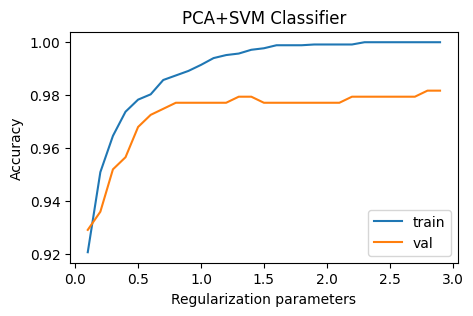

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x_list = [0.1 * i for i in range(1, 30)]
plt.figure(figsize=(5,3))
plt.plot(x_list, acc_list)
plt.plot(x_list, val_list)
plt.title('PCA+SVM Classifier')
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameters')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
print("Training Accuracy: {0:.2f}%".format(max(acc_list)*100))
print("Testing Accuracy: {0:.2f}%".format(max(val_list)*100))

Training Accuracy: 100.00%
Testing Accuracy: 98.17%


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def confussion_matrix(test_true, test_pred, test_class):
    cm = confusion_matrix(test_true, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax,cmap=plt.cm.Blues)
    plt.show()

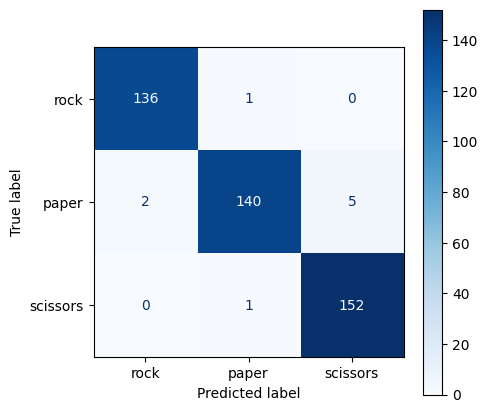

In [ ]:
test_classes = ['rock','paper','scissors']
svmClassifier = svm.SVC(C = opt_C, kernel = kernel)
svmClassifier.fit(train_x_pca, train_y.ravel())
pred_y = svmClassifier.predict(test_x_pca)
confussion_matrix(test_y, pred_y, test_classes)

In [ ]:
start_time = time.time()
opt_C, acc_list_without, val_list_without = svm_grid_search(C, kernel, train_x, train_y, test_x)

print("--- %s seconds ---" % (time.time() - start_time))

Regularization parameters: 0.1 Training Accuracy:  0.885208452312964
Regularization parameters: 0.1 Validation Accuracy:  0.8901601830663616
Regularization parameters: 0.2 Training Accuracy:  0.9223300970873787
Regularization parameters: 0.2 Validation Accuracy:  0.9336384439359268
Regularization parameters: 0.3 Training Accuracy:  0.9374643061107938
Regularization parameters: 0.3 Validation Accuracy:  0.9382151029748284
Regularization parameters: 0.4 Training Accuracy:  0.950028555111365
Regularization parameters: 0.4 Validation Accuracy:  0.9450800915331807
Regularization parameters: 0.5 Training Accuracy:  0.9554540262707024
Regularization parameters: 0.5 Validation Accuracy:  0.954233409610984
Regularization parameters: 0.6 Training Accuracy:  0.9597372929754426
Regularization parameters: 0.6 Validation Accuracy:  0.954233409610984
Regularization parameters: 0.7 Training Accuracy:  0.9631639063392348
Regularization parameters: 0.7 Validation Accuracy:  0.9565217391304348
Regulariza

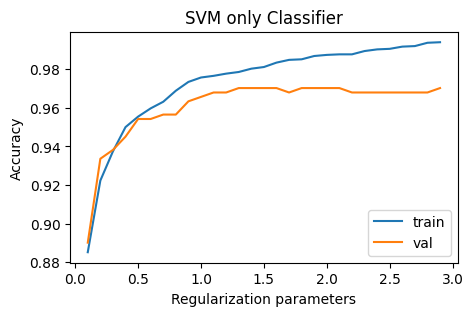

Training Accuracy: 99.40%
Testing Accuracy: 97.03%


In [ ]:
plt.figure(figsize=(5,3))
plt.plot(x_list, acc_list_without)
plt.plot(x_list, val_list_without)
plt.title('SVM only Classifier')
plt.ylabel('Accuracy')
plt.xlabel('Regularization parameters')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
print("Training Accuracy: {0:.2f}%".format(max(acc_list_without)*100))
print("Testing Accuracy: {0:.2f}%".format(max(val_list_without)*100))


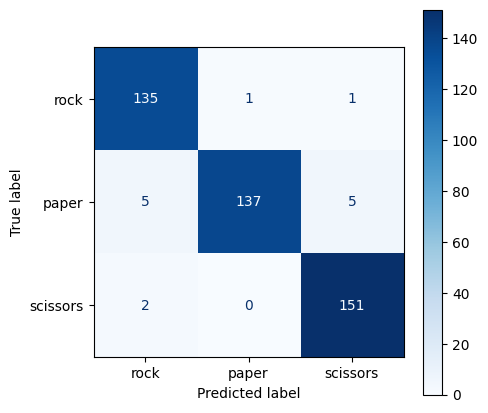

In [ ]:
svmClassifier.fit(train_x, train_y.ravel())
pred_y_without = svmClassifier.predict(test_x)
confussion_matrix(test_y, pred_y_without, test_classes)
